# EPA112 Programming for Data Science: Final Project
### Group 42: Angelica, Elena Deckert (6580300), Tadas Lukavicius(5525047)

# 1. Introduction

This cell installs all the necessary additional libraries.

In [18]:
!pip install pycountry -q
!pip install pycountry-convert -q
!pip install wbdata -q
!pip install ipywidgets -q
!pip install plotly -q
!pip install scikit-learn -q


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


This cell imports all the necessary libraries

In [36]:
import logging
import warnings
# Suppresses warning errors, there are too many of them there about caches from wbdata
logging.getLogger("shelved_cache.persistent_cache").setLevel(logging.ERROR)
warnings.simplefilter(action='ignore', category=FutureWarning)
import wbdata
import pandas as pd
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import pycountry_convert
import json
from data_handler import Data_Handler
from completeness import Completeness_Ranker
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import plotly.express as px

# 2. Datasets

## 2.1 WBData completeness analysis

First, we completed a completeness analysis on the World Bank data. This was done because the data provided by the World Bank had a lot of factors; however, a lot of them had a lot of missing data. This was done by selecting the indicators that we were interested in, namely:
- Gender Disaggregated Labor Database (GDLD)
- Country Climate and Development Report (CCDR)
- Sustainable Development Goals
- Sustainable Energy for All
- Gender Statistics 

For each of these categories, we got all the data and checked how many NaN values there were per factor. This gave us valuable insight into which data can provide the most information for our further research.

In the next cell, we provide an example of such an analysis for the _Sustainable Energy for All_ indicator. We wanted to avoid clutter in this notebook, so the complete analysis can be found in the "WBData explore" notebook.

In [20]:
se_summary, se_df = Completeness_Ranker.rank_indicators_by_completeness(35, 2000, 2025, 10)
print(se_summary.head(15))

Found 11 indicators in source 35
Fetching data for all indicators...


Fetching indicators: 100%|█████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.03s/it]


Retrieved 39126 data points


Calculating completeness: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 513.35it/s]

                    Indicator Code  \
1    1.1_TOTAL.FINAL.ENERGY.CONSUM   
6               3.1_RE.CONSUMPTION   
8     4.1.2_REN.ELECTRICITY.OUTPUT   
9      4.1_SHARE.RE.IN.ELECTRICITY   
0       1.1_ACCESS.ELECTRICITY.TOT   
3     1.3_ACCESS.ELECTRICITY.URBAN   
7   4.1.1_TOTAL.ELECTRICITY.OUTPUT   
5       2.1_SHARE.TOTAL.RE.IN.TFEC   
2     1.2_ACCESS.ELECTRICITY.RURAL   
4               2.1_ACCESS.CFT.TOT   
10    6.1_PRIMARY.ENERGY.INTENSITY   

                                       Indicator Name  Completeness  \
1               Total final energy consumption (TFEC)      0.610782   
6                   Renewable energy consumption (TJ)      0.610782   
8           Renewable energy electricity output (GWh)      0.610618   
9   Renewable electricity (% in total electricity ...      0.610618   
0       Access to electricity (% of total population)      0.604043   
3       Access to electricity (% of urban population)      0.604043   
7                      Total electricity outpu

## 2.2 Pulling the data

Next, we chose data depending on their completeness and interest in our research.

From the World Bank data, we chose:
- Renewable energy share: Renewable electricity share of total electricity output (%): Electricity generated by power plants using renewable resources as a share of total electricity output.
- Basic drinking water:	The percentage of people using at least basic water services. This indicator encompasses both people using basic water services as well as those using safely managed water services.

From the Environmental Performance Index by Yale, we chose:
- Species protection index: measures how well a country's terrestrial protected areas overlap with the ranges of its vertebrate, invertebrate, and plant species.
- Air Polution SO2 trend: measures exposure to ground-level sulfur dioxide using a country’s ambient ground-level concentration.
- Ambient PM2.5 from human resources: measures the exposure to fine particulate matter pollution from anthropogenic sources, such as the burning of fossil fuels, which are easier to influence through policy than natural sources.
- Marine Habitat Protection: measures the percentage of the area of important marine and coastal habitats under official protection within a country’s Exclusive Economic Zone(s).

From the Human Development Index by United Nations, we chose:
- GII: composite metric of gender inequality using three dimensions: reproductive health, empowerment and the labour market. A low GII value indicates low inequality between women and men, and vice-versa.
- Shares of seats in the parliament, female: percentage of parliamentary seats held by women.
- Labour force participation, female: percentage of women who are working or actively seeking work.
- Population with secondary education, female: percentage of women who have completed secondary education.

Note: we had to download Renewable energy consumption share data separately because the API to world bank had incomplete data. The data retrieved via the API had no data after 2015, thus we downloaded the data separately and imported it.

In the next cell, we get the said data from according sources.

In [21]:
# Initialise data indicators and relative names for the columns in the data
indicators_wb = { "SH.H2O.BASW.ZS" :  "Basic drinking water"}
indicators_yale = { "SPI" : "Species protection index",
              "SDA" : "Air Polution SO2 trend",
              "HPE" : "Ambient PM2.5 from human resources", 
              "MHP" : "Marine Habitat Protection"}
indicators_hdi = {"gii" : "GII",
                 "pr_f" : "Shares of seats in the parliament, female",
                 "lfpr_f" : "Labour force participation, female",
                 "se_f" : "Population with secondary education, female"}

# Get world bank data
wbdata = Data_Handler.get_data_WB(
    indicators_wb, 
    countries="all", 
    start_year=1990, 
    end_year=2025
 )
# Get HDI data
hdi_data = Data_Handler.get_data_HDI(
    filepath="HDR25_Composite_indices_complete_time_series.csv",
    indicators=indicators_hdi,
    countries=None,
    start_year=1990,
    end_year=2024
)
# Get EPI data
epi_data = Data_Handler.get_data_EPI(
    indicators=indicators_yale,
    countries=None,
    start_year=1990,
    end_year=2024
)

re_data = Data_Handler.get_renewable_energy_data(
    file_path="API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_130800.csv",
    start_year=1990,
    end_year=2024
)

In the next cell, we merge all data into one dataframe

In [22]:
# Rename columns for consistency
wbdata.rename(columns={'Country': 'country', 'Year': 'year'}, inplace=True)

# Pivot the HDI dataset so that each metric_name becomes a column
hdi_data_pivot = hdi_data.pivot_table(
    index=['country', 'year'],   
    columns='metric_name',       
    values='value'               
).reset_index()                  

# Pivot the EPI dataset 
epi_data_pivot = epi_data.pivot_table(
    index=['country', 'year'],
    columns='variable_name',     # Each variable_name becomes a column
    values='value'
).reset_index()

# Merge all three datasets on 'country' and 'year'
data = (
    wbdata
    .merge(hdi_data_pivot, on=['country', 'year'], how='outer')
    .merge(epi_data_pivot, on=['country', 'year'], how='outer')
    .merge(re_data, on=['country', 'year'], how='outer')
)

## 2.3 Data preprocessing

In this section, we complete all necessary data preprocessing.

To get a standardised list of country names, we will be using pycountry. This library contains an ISO list of country names. Additionally, some "countries' are actually regions (e.g. Eurozone, the world, etc), so we skipped those as we are interested in the dynamics between different countries. We used a mapping of countries that were picked manually, because different datasets had different names for countries (e.g. "Czezh Republic" and "Czechia"), which was saved in a JSON format in the file country_names_mapping.json. This approach was done in order to reduce clutter in the notebook.

In [23]:
# Create a set of official country names from the pycountry library
pycountry_names = set([c.name for c in pycountry.countries])
country_map = {}
for name in data['country'].unique():
    if name in pycountry_names:
        country_map[name] = name

# Load a mapping file that contains manual corrections for country names not recognised by pycountry
with open("country_names_mapping.json", "r", encoding="utf-8") as f:
    map_update = json.load(f)

# Update the country_map with custom name mappings
country_map.update(map_update)
data['country'] = data['country'].map(country_map)

# Drop rows where 'country' is NaN
data = data.dropna(subset=['country'])

# Group by country and year to ensure unique records per pair
# If there are duplicates, `.first()` keeps the first occurrence
data = data.groupby(['country', 'year'], as_index=False).first()


In the next cell, we make a continent variable, which will later help us identify patterns between different continents.

In [24]:
def get_continent(country_name):
    try:
        # Try to find the country by exact name first
        country = pycountry.countries.get(name=country_name)
        
        # If not found, try fuzzy search
        if country is None:
            country = pycountry.countries.search_fuzzy(country_name)[0]
        
        # Get ISO Alpha-2 code
        country_code = country.alpha_2
        
        # Convert to continent code and name
        continent_code = pycountry_convert.country_alpha2_to_continent_code(country_code)
        continent_name = pycountry_convert.convert_continent_code_to_continent_name(continent_code)
        
        return continent_name

    except Exception:
        return 'Unknown'

# Apply to your DataFrame
data['continent'] = data['country'].apply(get_continent)

After the previous cell, due to the mismatch between the names in the pycountry list and the dataset, a few countries were not identified. For these countries, we assigned the continent manually. This was done in the next two cells.

In [25]:
unknown_continent_countries = data[
    (data['continent'].isna()) | (data['continent'] == 'Unknown')
][['country']].drop_duplicates()

print(unknown_continent_countries)

                               country
1709  Democratic Republic Of The Congo
1884                        East Timor
3979                  Macao SAR, China
6108         Sint Maarten (Dutch part)
7288                    Western Sahara


In [26]:
data.loc[data["country"] == "Democratic Republic Of The Congo", "continent"] = "Africa"
data.loc[data["country"] == "Macao SAR, China", "continent"] = "Asia"
data.loc[data["country"] == "Sint Maarten (Dutch part)", "continent"] = "North America"
data.loc[data["country"] == "Western Sahara", "continent"] = "Africa"
data.loc[data["country"] == "East Timor", "continent"] = "Asia"

Later, we plotted the missing values by year in a bar graph.

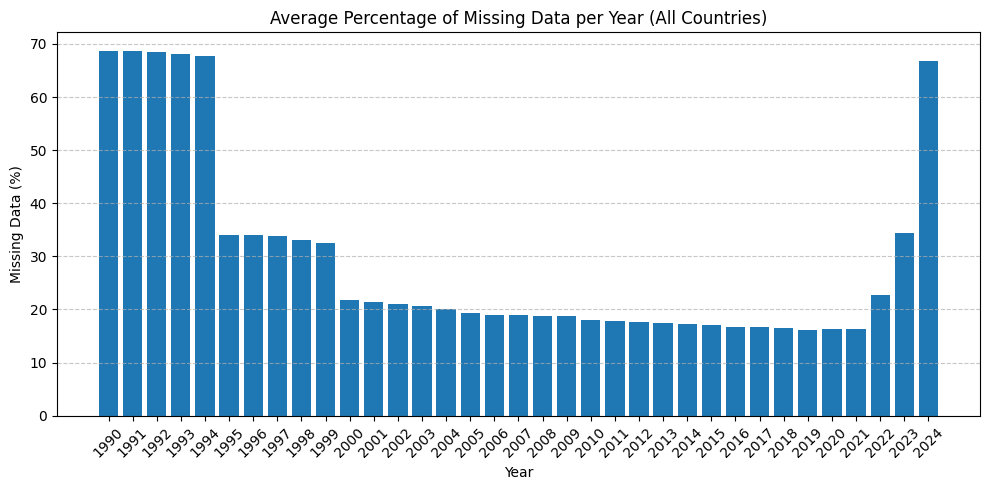

In [27]:
# Exclude trivial columns
cols_to_check = [c for c in data.columns if c not in ['year', 'country', 'continent']]

# Percentage of NaN values per year (average across all countries and columns)
nan_by_year = data.groupby('year')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)

# Plot NaN values
plt.figure(figsize=(10,5))
plt.bar(nan_by_year.index.astype(str), nan_by_year.values)
plt.title('Average Percentage of Missing Data per Year (All Countries)')
plt.xlabel('Year')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

As we can see from the bar graph, a lot of the missing data is before 2000 and after 2022, thus, we have decided to exclude this data from our dataset.

In [28]:
data = data[(data['year'] >= 2000) & (data['year'] <= 2022)]

Next, we plot countries and the percentage of missing values per country.

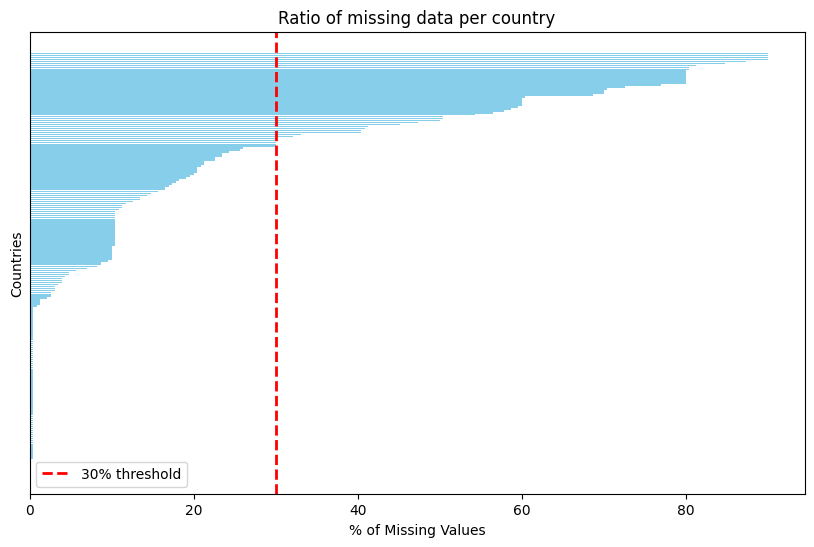

In [29]:
# Get NaN values by country
nan_by_country = data.groupby('country')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)
nan_by_country = nan_by_country.sort_values(ascending=False)

# Plot NaN values
plt.figure(figsize=(10,6))
plt.barh(range(len(nan_by_country)), nan_by_country.values, color='skyblue')  # use range for no labels
plt.axvline(x=30, color='red', linestyle='--', linewidth=2, label='30% threshold')  # red line at 30%
plt.xlabel('% of Missing Values')
plt.ylabel("Countries")
plt.title('Ratio of missing data per country')
plt.yticks([])  # remove y-axis labels
plt.legend()
plt.gca().invert_yaxis()  # largest on top
plt.show()


From the graph, we can see that a lot of the countries have a majority of their data missing. We have decided to exclude countries that have more than 70 per cent data missing, which is indicated by the red line in the graph.

In [30]:
def nan_mean_excluding_marine(x):
    # Exclude 'Marine Habitat Protection' if all NaN for this country
    if 'Marine Habitat Protection' in x.columns and x['Marine Habitat Protection'].isna().all():
        return x.drop(columns=['Marine Habitat Protection']).isna().mean().mean() * 100
    else:
        return x.isna().mean().mean() * 100
before_excl = len(data["country"].unique())
# Compute missing-data percentage per country
country_nan_percent = data.groupby('country')[cols_to_check].apply(nan_mean_excluding_marine)

# Keep only countries with <= 30% missing data
valid_countries = country_nan_percent[country_nan_percent <= 30].index

# Filter the main DataFrame
data = data[data['country'].isin(valid_countries)]
after_excl = len(data["country"].unique())

print(f"{before_excl - after_excl} countries removed from the data.")

43 countries removed from the data.


Now, we want to inspect the trends of missing data between different factors in our dataset.

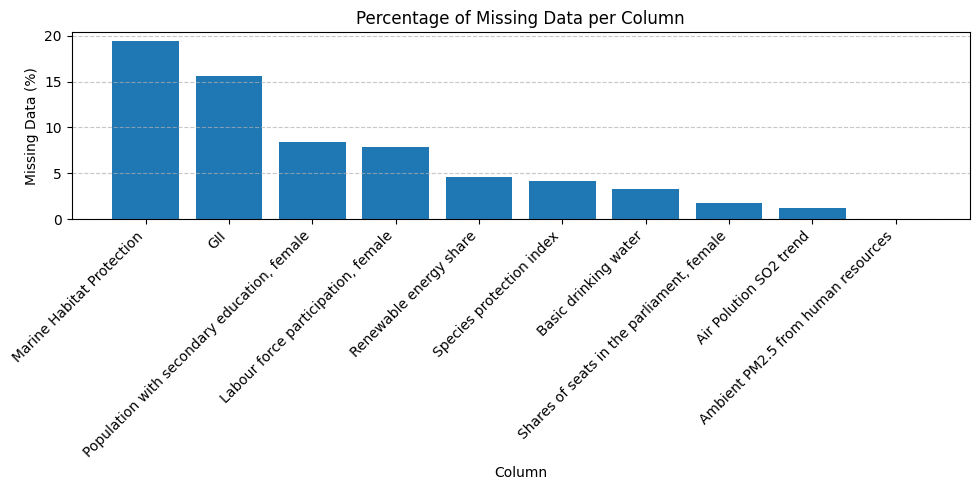


Missing data percentage per column (sorted):
Marine Habitat Protection                      19.411765
GII                                            15.652174
Population with secondary education, female     8.363171
Labour force participation, female              7.877238
Renewable energy share                          4.578005
Species protection index                        4.117647
Basic drinking water                            3.324808
Shares of seats in the parliament, female       1.790281
Air Polution SO2 trend                          1.176471
Ambient PM2.5 from human resources              0.000000
dtype: float64


In [31]:
# Get NaN values per column
nan_per_column = data[cols_to_check].isna().mean() * 100
nan_per_column_sorted = nan_per_column.sort_values(ascending=False)

# Plot NaN values
plt.figure(figsize=(10,5))
plt.bar(nan_per_column_sorted.index, nan_per_column_sorted.values)
plt.title(f'Percentage of Missing Data per Column')
plt.xlabel('Column')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nMissing data percentage per column (sorted):")
print(nan_per_column_sorted)

The highest factor in missing data is for Marine Habitat Protection. That is because there are landlocked countries, for example, Slovakia, which do not have access to seas or Oceans, and thus cannot have any marine habitat protection.

## 2.4 Uniformize data

Next, we look at the minimum and maximum values each column can obtain. All factors except for GII, are measured from 0 to 100. We have decided to multiply the GII by a factor of 100, as this will later help us visualize the results.

In [32]:
# Print min and max values of each column
min_max = data.agg(['min', 'max']).transpose().reset_index()
min_max.columns = ['Column', 'Min', 'Max']
print(min_max)

# Multiply GII by a 100
data['GII'] = data['GII'] * 100

                                         Column          Min            Max
0                                       country  Afghanistan       Zimbabwe
1                                          year         2000           2022
2                          Basic drinking water    18.682303          100.0
3                                           GII        0.004           0.84
4            Labour force participation, female         5.72           94.4
5   Population with secondary education, female     1.761277          100.0
6     Shares of seats in the parliament, female          0.0       57.54717
7                        Air Polution SO2 trend          0.0          100.0
8            Ambient PM2.5 from human resources          0.0          100.0
9                     Marine Habitat Protection          0.0          100.0
10                     Species protection index          0.0          100.0
11                       Renewable energy share          0.0           96.0
12          

## 2.5 Basic Stats

Next we tried to get a general overview of the numeric value columns

In [33]:
data.describe()

,year,Basic drinking water,GII,"Labour force participation, female","Population with secondary education, female","Shares of seats in the parliament, female",Air Polution SO2 trend,Ambient PM2.5 from human resources,Marine Habitat Protection,Species protection index,Renewable energy share
count,3910.000000,3780.000000,3298.000000,3602.000000,3583.000000,3840.000000,3864.000000,3910.000000,3151.000000,3749.000000,3731.000000
mean,2011.000000,85.716722,37.075591,50.124606,55.265431,18.876819,66.454451,43.563964,22.111933,36.525020,32.332485
std,6.634098,17.610250,19.620179,15.601038,30.642818,11.432121,32.417434,30.444452,22.481686,27.474321,29.029545
min,2000.000000,18.682303,0.400000,5.720000,1.761277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005.000000,77.797856,19.300000,41.802500,27.016138,10.000000,41.800000,19.700000,3.700000,13.000000,7.300000
50%,2011.000000,93.756772,38.100000,51.600000,56.299999,17.449664,70.850000,37.100000,16.000000,32.200000,23.900000
75%,2017.000000,99.124099,53.100000,59.207500,85.219448,25.903614,100.000000,64.850000,35.400000,57.400000,52.000000
max,2022.000000,100.000000,84.000000,94.400000,100.000000,57.547170,100.000000,100.000000,100.000000,100.000000,96.000000


Next, we examine the number of missing values in the dataset to determine an appropriate method for handling them. This step is important because missing data can negatively impact analyses, particularly in machine learning applications.

In [34]:
data.isna().sum()

country                                          0
year                                             0
Basic drinking water                           130
GII                                            612
Labour force participation, female             308
Population with secondary education, female    327
Shares of seats in the parliament, female       70
Air Polution SO2 trend                          46
Ambient PM2.5 from human resources               0
Marine Habitat Protection                      759
Species protection index                       161
Renewable energy share                         179
continent                                        0
dtype: int64

We can see that there is still a significant number of missing values. For 'Marine Habitat Protection' we decided to check if the values are missing for a country entirely. If that is the case we decided to replace the values with 100 as we assume it is a landlcked country and therefore does not have any entries. The other columns we interpolated the values linearly for each country based on the exisiting years.

In [37]:
# fill landlock with 100 so if  acountry has only emty values for marine habitant then they are most likely landlocked and therefore we put 100 for all 
def fill_marine_habitat(group):
    if group['Marine Habitat Protection'].isna().all():
        group['Marine Habitat Protection'] = 100
    return group

data = data.groupby('country', group_keys=False).apply(fill_marine_habitat)

# Interpolate missing values per country based on previous and next year
data = (
    data.sort_values(['country', 'year'])
        .groupby('country', group_keys=False)
        .apply(lambda g: g.interpolate(method='linear', limit_direction='both'))
)

data.isna().sum()

country                                          0
year                                             0
Basic drinking water                            46
GII                                            207
Labour force participation, female              69
Population with secondary education, female     69
Shares of seats in the parliament, female        0
Air Polution SO2 trend                          46
Ambient PM2.5 from human resources               0
Marine Habitat Protection                        0
Species protection index                       161
Renewable energy share                          46
continent                                        0
dtype: int64

After doing this we still have missing values. This can be caused when countries are completely missing entries for a columns and therfore it is not possiblle to interpolate. In these cases we decided to fill the values with the mean of the according continent for each year. This is a limitation beause it is a strong assumtion to fill the values simply based on the continent without considering differences within continents.

In [38]:
cols = [
    'Renewable energy share',
    'Basic drinking water',
    'GII',
    'Labour force participation, female',
    'Population with secondary education, female',
    'Air Polution SO2 trend',
    'Species protection index'
]

# Check per country if all values in a column are missing
missing_summary = (
    data.groupby('country')[cols]
        .apply(lambda g: g.isna().all())
)

print("Number of countries entirely missing per indicator:")
print(missing_summary.sum())

KeyError: "Columns not found: 'Population with secondary education', 'Labour force participation'"

In [ ]:
for col in cols:
    data[col] = data.groupby(['continent', 'year'])[col].transform(
        lambda x: x.fillna(x.mean())
    )

In [ ]:
data.isna().sum()

# ADD MISSING VALUES

# 3. Data Exploration
## 3.1 Distribution and Outliers
We start by getting a general idea for the values of our data set by plotting histograms and boxplots. With this we understand the distribution of values and can also see possible outliers.

In [ ]:
numeric_cols = [col for col in data.select_dtypes(include=np.number).columns if col not in ['year']]
data[numeric_cols].hist(figsize=(15,10), bins=20)

## 3.2 Continent & Country Analysis

Are some continents over or under represented

In [ ]:
data['continent'].value_counts().plot(kind='bar', title='Number of observations per continent')
plt.show()

Is there generally a difference between continents and does it make sense to explore this.

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(data=data, x='continent', y=col, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

fig = px.choropleth(
    data_frame=data,
    locations="country",
    locationmode="country names",
    color="GII",
    hover_name="country",
    animation_frame="year",
    color_continuous_scale="Viridis",
    title="Global Gender Inequality Index (GII) over time"
)

# set the layout of the figure
fig.update_layout(
    width=1200,      
    height=700,      
    coloraxis_colorbar=dict(
        title="GII",    
        thickness=25,  
        lenmode="fraction",
        len=0.8        
    ),
    title=dict(font=dict(size=20))  
)

fig.show()


## 3.3 Correlation

In [ ]:
corr_matrix = data[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
data_2022 = data[data["year"] == 2022]

# Compute correlation matrix
corr = data_2022[numeric_cols].corr()

# Find pairs with high correlation (> 0.7)
high_corr = []
for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2 and abs(corr.loc[col1, col2]) > 0.7:
            pair = tuple(sorted([col1, col2]))
            if pair not in high_corr:
                high_corr.append(pair)

# Plot scatterplots for highly correlated pairs
for col1, col2 in high_corr:
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=data_2022, x=col1, y=col2, hue='continent')
    plt.title(f'Scatterplot: {col1} vs {col2}\nCorrelation: {corr.loc[col1, col2]:.2f}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend(title='Continent')
    plt.show()


In [ ]:
from math import ceil

corr = data[numeric_cols].corr()

# Relationships with 0.5 < correlation <= 0.7
high_corr = []
for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2 and 0.5 < abs(corr.loc[col1, col2]) :
            pair = tuple(sorted([col1, col2]))
            if pair not in high_corr:
                high_corr.append(pair)

n_cols = 4
n_rows = ceil(len(high_corr)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Plot each pair
for i, (x_col, y_col) in enumerate(high_corr):
    sns.scatterplot(data=data, x=x_col, y=y_col, hue='continent', ax=axes[i])
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel(y_col)
    axes[i].set_title(f'Corr: {corr.loc[x_col, y_col]:.2f}')
    axes[i].legend_.remove()  

# Remove any unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.9), loc='upper left', title='Continent')

plt.tight_layout()
plt.show()

## 3.4 Temporal Trends

In [ ]:
country_name = 'Lesotho'  

country_df = data[data['country'] == country_name]
 

plot_df = country_df.melt(id_vars='year', value_vars=numeric_cols, 
                          var_name='Indicator', value_name='Value')

plt.figure(figsize=(12,6))
sns.lineplot(data=plot_df, x='year', y='Value', hue='Indicator', marker='o')
plt.title(f'Development over time for {country_name}')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()

In [ ]:
continents = data['continent'].unique()

# Grid layout
n_cols = 3
n_rows = int(np.ceil(len(continents)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
axes = axes.flatten()

for i, continent in enumerate(continents):
    continent_df = data[data['continent'] == continent]
    yearly_mean = continent_df.groupby('year')[numeric_cols].mean()
    
    # Plot each indicator
    for col in numeric_cols:
        axes[i].plot(yearly_mean.index, yearly_mean[col], marker='o', label=col)
    
    axes[i].set_title(continent)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Value')

# Single legend
fig.legend(numeric_cols, bbox_to_anchor=(1.02, 0.9), loc='upper left', title='Indicator')

plt.tight_layout()
plt.show()


In [ ]:
continents = data['continent'].unique()
years = sorted(data['year'].unique())

plt.figure(figsize=(12,6))

for continent in continents:
    correlations = []
    df_cont = data[data['continent'] == continent]
    
    for year in years:
        df_year = df_cont[df_cont['year'] == year][['GII', 'Renewable energy share']].dropna()
        if len(df_year) > 1:
            corr = df_year['GII'].corr(df_year['Renewable energy share'])
            correlations.append(corr)
        else:
            correlations.append(None)
    
    plt.plot(years, correlations, marker='o', label=continent)

plt.title('Correlation between GII and Renewable Energy Share over time by Continent')
plt.xlabel('Year')
plt.ylabel('Correlation')
plt.ylim(-1,1)
plt.grid(True)
plt.legend(title='Continent')
plt.show()



# 4. Machine Learning

First we will do a clustering analysis of gender equality and environmental sustainability overtime, comparing the clusters from the first year in the data set to the ones of the last year.

In [ ]:
oldest_idx = data.groupby('country')['year'].idxmin()
latest_idx = data.groupby('country')['year'].idxmax()

oldest = data.loc[oldest_idx, ['country'] + numeric_cols].set_index('country')
latest = data.loc[latest_idx, ['country'] + numeric_cols].set_index('country')


In [ ]:
def cluster_and_plot(df, n_clusters=3, title='Clusters'):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='Set2', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

    return labels

In [ ]:
latest_labels = cluster_and_plot(latest, n_clusters=3, title='Clusters: Latest Year')
oldest_labels = cluster_and_plot(oldest, n_clusters=3, title='Clusters: Oldest Year')

In [ ]:
def analyze_clusters(df, labels, dataset_name='Dataset'):
    df = df.copy()
    df['Cluster'] = labels

    print(f"Cluster Analysis: {dataset_name}")
    print(df.groupby('Cluster').mean().round(2))
    print(df.groupby('Cluster').std().round(2))
    print(df['Cluster'].value_counts())

analyze_clusters(latest, latest_labels, dataset_name='Latest Year')
analyze_clusters(oldest, oldest_labels, dataset_name='Oldest Year')

# Old Stuff

### Renewable energy share

In [ ]:
top_countries = data.groupby('country')['Renewable energy share'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.xticks(rotation=45)
plt.title('Top 10 Countries by Renewable Energy Share')
plt.ylabel('Renewable Energy Share')
plt.ylim(85, 100)
plt.xlabel('Country')
plt.show()

In [ ]:
bottom_countries = (
    data[data['Renewable energy share'] > 0]
    .groupby('country')['Renewable energy share']
    .mean()
    .sort_values(ascending=True)
    .head(10)
)
sns.barplot(x=bottom_countries.index, y=bottom_countries.values)
plt.xticks(rotation=45)
plt.title('Bottom 10 Countries by Renewable Energy Share (Excluding Zero)')
plt.ylabel('Renewable Energy Share')
plt.xlabel('Country')
plt.show()

In [ ]:
sns.boxplot(data=merged, x='continent', y='Renewable_Energy_Share')
plt.title('Renewable Energy Share by Continent')
plt.ylabel('Renewable Energy Share')
plt.xlabel('Continent')
plt.show()

### GII

In [ ]:
top_countries = merged.groupby('country')['GII'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.xticks(rotation=45)
plt.title('Top 10 Countries by GII')
plt.ylabel('GII')
plt.xlabel('Country')
plt.show()

In [ ]:
bottom_countries = merged.groupby('country')['GII'].mean().sort_values(ascending=True).head(10)
sns.barplot(x=bottom_countries.index, y=bottom_countries.values)
plt.xticks(rotation=45)
plt.title('Bottom 10 Countries by GII')
plt.ylabel('GII')
plt.xlabel('Country')
plt.show()

In [ ]:
sns.boxplot(data=merged, x='continent', y='GII')
plt.title('GII by Continent')
plt.ylabel('GII')
plt.xlabel('Continent')
plt.show()

### Let's see their relation

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=data, x='Renewable energy share', y='GII', legend=True)
plt.title('Relationship between Gender Inequality Index (GII) and Renewable Energy Share')
plt.xlabel('Renewable Energy Share')
plt.ylabel('Gender Inequality Index (GII)')
plt.show()

### Correlation exploration

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

In [ ]:
corr = merged[merged["year"]==2022].corr(numeric_only=True)

# Relationships with correlation > 0.7
high_corr = []
for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2 and abs(corr.loc[col1, col2]) > 0.7:
            pair = tuple(sorted([col1, col2]))
            if pair not in high_corr:
                high_corr.append(pair)

for col1, col2 in high_corr:
    sns.scatterplot(data=merged, x=col1, y=col2, hue='continent', legend=True)
    plt.title(f'Scatterplot: {col1} vs {col2}\nCorrelation: {corr.loc[col1, col2]:.2f}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

In [ ]:
corr = merged.corr(numeric_only=True)

# Relationships with 0.5 < correlation <= 0.7
medium_corr = []
for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2 and 0.5 < abs(corr.loc[col1, col2]) <= 0.7:
            pair = tuple(sorted([col1, col2]))
            if pair not in medium_corr:
                medium_corr.append(pair)

for col1, col2 in medium_corr:
    sns.scatterplot(data=merged, x=col1, y=col2, hue='continent', legend=True)
    plt.title(f'Scatterplot: {col1} vs {col2}\nCorrelation: {corr.loc[col1, col2]:.2f}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

## GII Correlation

In [ ]:
sns.pairplot(merged[['GII', 
                     'Labour force participation', 
                     'Shares of seats in the parliament', 
                     'population with secondary education', 
                     'continent']], 
             hue='continent')
plt.show()


In [ ]:
import ipywidgets as widgets
from IPython.display import display

variables = ['Labour force participation',
             'Shares of seats in the parliament',
             'population with secondary education']

agg_df = merged.groupby('country')[variables + ['GII']].mean().reset_index()

for var in variables:
    min_val = agg_df[var].min()
    max_val = agg_df[var].max()
    agg_df[var] = (agg_df[var] - min_val) / (max_val - min_val)


def update_plot(w1, w2, w3):
    total = w1 + w2 + w3
    if total == 0:
        return
    w1, w2, w3 = w1/total, w2/total, w3/total

    agg_df['weighted_indecators'] = (w1*agg_df[variables[0]] +
                                    w2*agg_df[variables[1]] +
                                    w3*agg_df[variables[2]])
    
    corr = agg_df['weighted_indecators'].corr(agg_df['GII'])
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=agg_df, x='weighted_indecators', y='GII', s=100)
    plt.title(f'Weighted Indicators vs GII\nCorrelation: {corr:.2f}')
    plt.xlabel('Weighted Indicator')
    plt.ylabel('GII')
    plt.show()

w1_slider = widgets.FloatSlider(value=0.33, min=0, max=1, step=0.05, description='Labour')
w2_slider = widgets.FloatSlider(value=0.33, min=0, max=1, step=0.05, description='Parliament')
w3_slider = widgets.FloatSlider(value=0.34, min=0, max=1, step=0.05, description='Education')

sliders = widgets.VBox([w1_slider, w2_slider, w3_slider])
figure = widgets.interactive_output(update_plot, {'w1': w1_slider, 'w2': w2_slider, 'w3': w3_slider})

display(sliders, figure)
